In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exp_name = "exp_compass"
exp_number = "exp_debug"
base_path = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/"
data_path = base_path + "/my_code/Bayesian-fairness/data"
save_path = base_path + f"/my_code/Bayesian-fairness/results/continuous/{exp_name}/{exp_number}"

# load data


In [3]:
def encode_data(data,unique_values):
    encoded_value = np.array([])
    for i, d in data.iterrows():
        # encode feature to an index represents the unique value.
        index = np.argmax((d.values == unique_values).all(axis=1))
        encoded_value = np.append(encoded_value, index)
    return encoded_value.astype(int)

In [4]:
# set atributes
Z_atr = ["sex", "race"]
X_atr = ['age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree']
Y_atr = 'two_year_recid'

# clip_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]

In [5]:
dataset = pd.read_csv(data_path + "/compas.csv")

In [6]:
# get distinct values
unique_z = np.unique(dataset[Z_atr].values, axis=0)
n_z = len(unique_z)

unique_y = np.unique(dataset[Y_atr].values, axis=0)
n_y = len(unique_y)

unique_x = np.unique(dataset[X_atr].values, axis=0)
n_x = len(unique_x)

In [7]:
print("Unique Z values:", n_z)
print("Unique X values:", n_x)
print("Unique Y values:", n_y)

Unique Z values: 12
Unique X values: 604
Unique Y values: 2


In [8]:
# encode z for convenience
dataset["z"] = encode_data(dataset[Z_atr], unique_values=unique_z)

In [9]:
Z_atr = "z"

In [10]:
train_data = dataset.iloc[0:6000]
test_data = dataset.iloc[6000:]

In [11]:
print("training size:", train_data.shape)
print("testing size:", test_data.shape)

training size: (6000, 10)
testing size: (1214, 10)


# model

In [12]:
def calc_freq(data, n):
    """ calculate frequency of 1D array"""
    P = np.zeros(n)
    for value in range(n):
        mask =  data == value
        P[value] = mask.mean()
    return P

def get_models(data):
    # Py
    Py = calc_freq(data[Y_atr], n_y)
    
    # Pz_y
    Pz_y = np.zeros((n_z, n_y))
    for y in range(n_y):
        mask = data[Y_atr] == y
        Pz_y[:, y] = calc_freq(data.loc[mask, Z_atr], n_z)
    
    # Py_x
    from sklearn.linear_model import LogisticRegression
    model_y_x = LogisticRegression(max_iter=1000)
    model_y_x.fit(X = data[X_atr], y = data[Y_atr])
    
    # Pz_yx
    input_features = [Y_atr] + X_atr
    model_z_yx = LogisticRegression(max_iter=1000)
    model_z_yx.fit(X = data[input_features], y = data[Z_atr])
    
    return Py, Pz_y, model_y_x, model_z_yx

In [13]:
test_model = get_models(test_data)

# Train policy

In [14]:
num_X = n_x # number of features
num_Y = n_y # number of outcomes
num_Z = n_z # number of sensitive features
num_A = 2 # number of actions

In [15]:
# parameters
n_iter = 400 # number of itteration for SGD
lr = 1.0 # learning rate
l = 0.5 # lambda

# Functions

In [16]:
def get_eye_utility(size):
    return np.eye(size)

utility = get_eye_utility(size=2)

# Algorithm
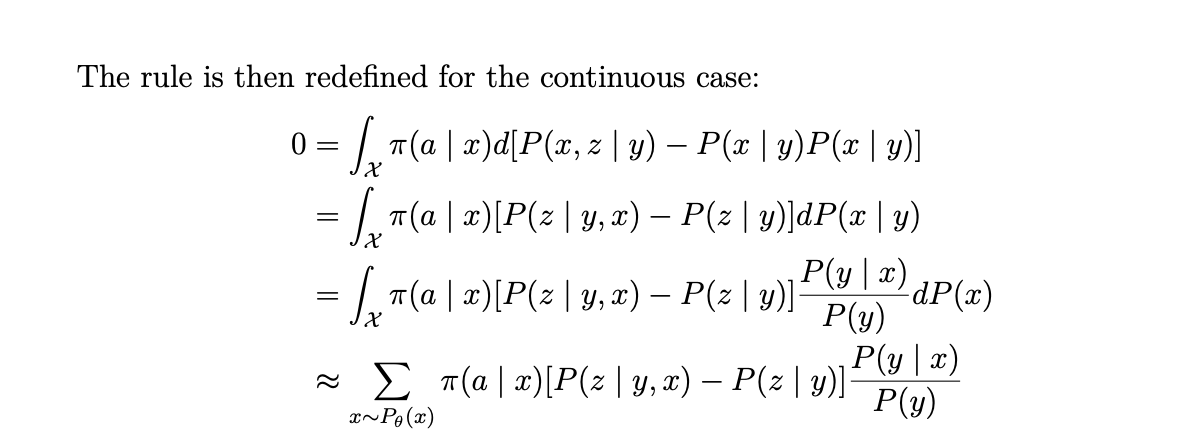

In [90]:
def get_fairness_loss(Pa_x, Py, Pz_y, model_y_x, model_z_yx):
    delta = (model_z_yx - Pz_y) * (model_y_x / Py)
    delta = tf.math.abs(delta)
    delta = tf.reshape(delta,(-1,1))
    f =  Pa_x * delta
#     tf.print("shape delta", tf.shape(delta))
#     tf.print("shape Pa_x",tf.shape(Pa_x))
#     tf.print("shape f",tf.shape(f))
#     tf.print(tf.shape(f))
#     tf.print(f)
    
    return tf.math.reduce_mean(f) * 20

In [91]:
import tensorflow as tf
from tensorflow.python.keras.engine import data_adapter


utility_tracker = tf.keras.metrics.Mean(name="utility")
fairness_tracker = tf.keras.metrics.Mean(name="fairness")


class LogisticRegresionTF(tf.keras.Model):
    """
    logistic regresion model , tensorflow
    """
    def __init__(self, input_dim, l):
        super(LogisticRegresionTF, self).__init__()
        self.l = l
        
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, 1), dtype="float32"),
            trainable=True,
        )
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(), dtype="float32"),
            trainable=True
        )

    def call(self, inputs):
        return tf.nn.sigmoid(tf.matmul(inputs,self.w) + self.b)

    def train_step(self, data):
        x, y = data
        x, Py, Pz_y, model_y_x, model_z_yx = x[:,:6], x[:,6],x[:,7],x[:,8],x[:,9]
        # Run forward pass.
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            utility = self.compute_loss(x, y, y_pred)
            fairness = get_fairness_loss(y_pred, Py, Pz_y, model_y_x, model_z_yx)
            loss = (1-self.l) * utility + self.l * fairness 
            
        self._validate_target_and_loss(y, loss)
        # Run backwards pass.
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        
        # update metrics
        utility_tracker.update_state(utility)
        fairness_tracker.update_state(fairness)
        metrics = self.compute_metrics(x, y, y_pred,None)
        metrics["fairness_loss"] = fairness_tracker.result()  
        metrics["utility"] = utility_tracker.result() 
#         tf.print(fairness_loss)
        return metrics
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return self.compiled_loss.metrics + self.compiled_metrics.metrics + [fairness_tracker, utility_tracker]

In [92]:
Py, Pz_y, model_y_x, model_z_yx = get_models(train_data)

In [93]:
data_Py = [Py[y] for y in train_data[Y_atr].values]
data_Pz_y = [Pz_y[z, y] for z, y in train_data[[Z_atr,Y_atr]].values]

predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])
data_Py_z = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Py_z[i] = predicted_proba_Py_x[i][datum[Y_atr]]
    
predicted_proba_Pz_yx = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr])
data_Pz_yx = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Pz_yx[i] = predicted_proba_Pz_yx[i][datum[Z_atr]]

In [94]:
input_dataset = tf.data.Dataset.from_tensor_slices((train_data[X_atr].astype("float32").values,
           data_Py,
           data_Pz_y,
           data_Py_z,
           data_Pz_yx)
)
labels_dataset = tf.data.Dataset.from_tensor_slices(train_data[Y_atr])
tf_train_dataset = tf.data.Dataset.zip((input_dataset, labels_dataset))
tf_train_dataset.shuffle(1000).batch(64).repeat()

<RepeatDataset element_spec=((TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [95]:
policy = LogisticRegresionTF(input_dim=len(X_atr), l = 0.5)

In [96]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
policy.compile(optimizer=optimizer,
               loss = "BinaryCrossentropy",
               metrics = ["accuracy"])

In [97]:
in_df = train_data[X_atr].astype("float32")
in_df["Py"] = data_Py
in_df["Pz_y"] = data_Pz_y
in_df["Py_z"] = data_Py_z
in_df["Pz_yx"] = data_Pz_yx

In [98]:
in_df

age_cat  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0         2.0            0.0             0.0              0.0           0.0   
1         1.0            0.0             0.0              0.0           0.0   
2         0.0            0.0             0.0              1.0           4.0   
3         0.0            0.0             1.0              0.0           1.0   
4         1.0            0.0             0.0              0.0           2.0   
...       ...            ...             ...              ...           ...   
5995      1.0            0.0             0.0              0.0          22.0   
5996      1.0            0.0             0.0              0.0           0.0   
5997      2.0            0.0             0.0              0.0           2.0   
5998      1.0            0.0             0.0              0.0           5.0   
5999      2.0            0.0             0.0              0.0           1.0   

      c_charge_degree     Py      Pz_y      Py_z     Pz_yx  
0                 1.0  0.551  0.049002  0.806851  0.059295  
1                 1.0  0.449  0.509651  0.330786  0.380325  
2                 1.0  0.449  0.509651  0.690225  0.618515  
3                 1.0  0.551  0.351180  0.436171  0.478386  
4                 1.0  0.551  0.049002  0.598783  0.052283  
...               ...    ...       ...       ...       ...  
5995              1.0  0.449  0.509651  0.933514  0.837547  
5996              1.0  0.449  0.004454  0.330786  0.011815  
5997              1.0  0.449  0.242019  0.245004  0.401558  
5998              0.0  0.551  0.351180  0.524162  0.397598  
5999              1.0  0.551  0.093164  0.782034  0.112245  

[6000 rows x 10 columns]

In [99]:
v1 = tf.Variable([1,2,3])
v2 = tf.Variable([1,2,3])
v1*v2

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 4, 9], dtype=int32)>

In [100]:
history["loss"]

In [101]:
history = policy.fit(x = in_df.astype("float32"),
                     y = train_data[Y_atr],
                     epochs=200,
                     batch_size=64,
                     shuffle=True).history

Epoch 1/200
94/94 [==============================] - 0s 422us/step - loss: 0.7105 - accuracy: 0.4470 - fairness: 0.6878 - utility: 0.7105 - fairness_loss: 0.7489
Epoch 2/200
94/94 [==============================] - 0s 364us/step - loss: 0.7639 - accuracy: 0.5510 - fairness: 0.5211 - utility: 0.7638 - fairness_loss: 0.5397
Epoch 3/200
94/94 [==============================] - 0s 363us/step - loss: 0.7892 - accuracy: 0.5510 - fairness: 0.4759 - utility: 0.7893 - fairness_loss: 0.4935
Epoch 4/200
94/94 [==============================] - 0s 369us/step - loss: 0.7995 - accuracy: 0.5510 - fairness: 0.4563 - utility: 0.7995 - fairness_loss: 0.4646
Epoch 5/200
94/94 [==============================] - 0s 381us/step - loss: 0.8034 - accuracy: 0.5510 - fairness: 0.4455 - utility: 0.8036 - fairness_loss: 0.4468
Epoch 6/200
94/94 [==============================] - 0s 368us/step - loss: 0.8028 - accuracy: 0.5510 - fairness: 0.4399 - utility: 0.8028 - fairness_loss: 0.4442
Epoch 7/200
94/94 [=========

94/94 [==============================] - 0s 363us/step - loss: 0.8112 - accuracy: 0.5510 - fairness: 0.3036 - utility: 0.8116 - fairness_loss: 0.3047
Epoch 102/200
94/94 [==============================] - 0s 360us/step - loss: 0.8102 - accuracy: 0.5510 - fairness: 0.3048 - utility: 0.8100 - fairness_loss: 0.3073
Epoch 103/200
94/94 [==============================] - 0s 360us/step - loss: 0.8111 - accuracy: 0.5510 - fairness: 0.3036 - utility: 0.8109 - fairness_loss: 0.2994
Epoch 104/200
94/94 [==============================] - 0s 368us/step - loss: 0.8130 - accuracy: 0.5510 - fairness: 0.3015 - utility: 0.8129 - fairness_loss: 0.3045
Epoch 105/200
94/94 [==============================] - 0s 356us/step - loss: 0.8099 - accuracy: 0.5510 - fairness: 0.3044 - utility: 0.8099 - fairness_loss: 0.2996
Epoch 106/200
94/94 [==============================] - 0s 351us/step - loss: 0.8121 - accuracy: 0.5510 - fairness: 0.3022 - utility: 0.8120 - fairness_loss: 0.3073
Epoch 107/200
94/94 [=========

94/94 [==============================] - 0s 491us/step - loss: 0.8169 - accuracy: 0.5510 - fairness: 0.2951 - utility: 0.8167 - fairness_loss: 0.2936
Epoch 152/200
94/94 [==============================] - 0s 350us/step - loss: 0.8170 - accuracy: 0.5510 - fairness: 0.2949 - utility: 0.8168 - fairness_loss: 0.2899
Epoch 153/200
94/94 [==============================] - 0s 349us/step - loss: 0.8172 - accuracy: 0.5510 - fairness: 0.2949 - utility: 0.8172 - fairness_loss: 0.2965
Epoch 154/200
94/94 [==============================] - 0s 351us/step - loss: 0.8155 - accuracy: 0.5510 - fairness: 0.2965 - utility: 0.8154 - fairness_loss: 0.2952
Epoch 155/200
94/94 [==============================] - 0s 351us/step - loss: 0.8164 - accuracy: 0.5510 - fairness: 0.2956 - utility: 0.8167 - fairness_loss: 0.2952
Epoch 156/200
94/94 [==============================] - 0s 351us/step - loss: 0.8161 - accuracy: 0.5510 - fairness: 0.2956 - utility: 0.8154 - fairness_loss: 0.2885
Epoch 157/200
94/94 [=========

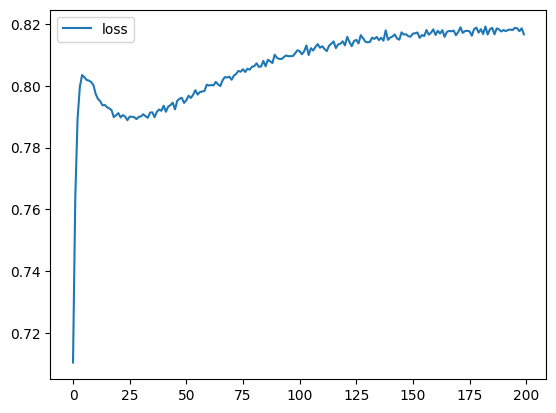

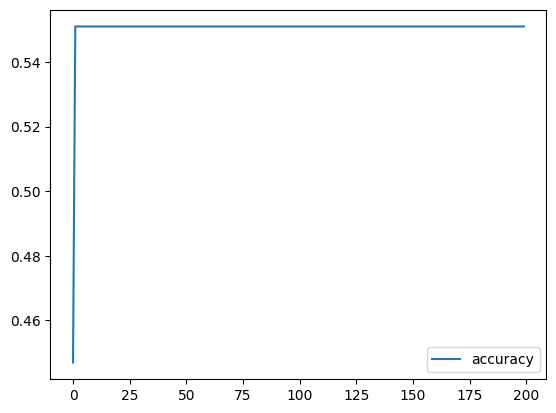

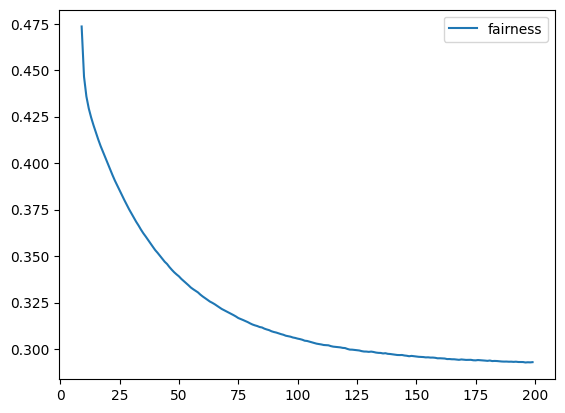

In [102]:
plt.figure()
plt.plot(history["loss"],label="loss")
# plt.plot(history["val_loss"],label="val_loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["accuracy"],label="accuracy")
# plt.plot(history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(pd.DataFrame(history["fairness_loss"]).rolling(10).mean(),label="fairness")
# plt.plot(history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

In [30]:
# input_x = [train_data[X_atr].astype("float32"),
#            data_Py,
#            data_Pz_y,
#            data_Py_z,
#            data_Pz_yx]

# history = policy.fit(tf_train_dataset,
#                      epochs=200).history

# evaluate

In [31]:
def get_fairness(policy, model_delta):
    (X, Y, Z) = model_delta.shape
    fairness = 0
    for y in range(Y):
        for z in range(Z):
            delta = np.matmul(policy, model_delta[:, y , z ])
            fairness += np.linalg.norm(delta, 1)
    return fairness

In [37]:
def get_utility(policy, model, utility):
    """
    Calculate expected utility
    Todo: vectorize operation - minor
    """
    A, X = policy.shape
    Y = A
    Eu = 0
    for x in range(X):
        for y in range(Y):
            for a in range(A):
                Eu += utility[a,y] * policy[a,x] * model.Pxy[x, y]
                
    return Eu

In [38]:
data_Py = [Py[y] for y in train_data[Y_atr].values]
data_Pz_y = [Pz_y[z, y] for z, y in train_data[[Z_atr,Y_atr]].values]

predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])
data_Py_z = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Py_z[i] = predicted_proba_Py_x[i][datum[Y_atr]]
    
predicted_proba_Pz_yx = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr])
data_Pz_yx = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Pz_yx[i] = predicted_proba_Pz_yx[i][datum[Z_atr]]

In [49]:
p_a_x

array([[0.87724745, 0.12275257],
       [0.785956  , 0.21404399],
       [0.4993543 , 0.5006457 ],
       ...,
       [0.84522396, 0.15477602],
       [0.6211905 , 0.3788095 ],
       [0.8620141 , 0.13798587]], dtype=float32)

In [50]:
prob_columns
p_a_x = p_a_x.T

['Py', 'Pz_y', 'Py_z', 'Pz_yx']

In [61]:
C = 0
for i, (py, pz_y, py_z, pz_yx) in enumerate(in_df[prob_columns].values): 
    delta =  (pz_yx - pz_y) * (py_z / py)
    for a in range(2):
        C += p_a_x[a,i] * np.abs(delta)

In [62]:
C / 6000

0.07433977115727088

In [52]:
p_a_x[a,i]

IndexError: index 2 is out of bounds for axis 1 with size 2

In [42]:
in_df.columns

Index(['age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_degree', 'Py', 'Pz_y', 'Py_z', 'Pz_yx'],
      dtype='object')

In [45]:
prob_columns = ['Py', 'Pz_y', 'Py_z', 'Pz_yx']
in_df[prob_columns].values

array([[0.551     , 0.04900181, 0.80685061, 0.05929492],
       [0.449     , 0.50965108, 0.33078559, 0.38032456],
       [0.449     , 0.50965108, 0.69022478, 0.61851474],
       ...,
       [0.449     , 0.2420193 , 0.24500393, 0.40155799],
       [0.551     , 0.35117967, 0.52416174, 0.39759815],
       [0.551     , 0.09316394, 0.78203354, 0.11224502]])

In [36]:
pa_x

NameError: name 'pa_x' is not defined

In [34]:
data_Py_z

array([0.80685061, 0.33078559, 0.69022478, ..., 0.24500393, 0.52416174,
       0.78203354])

In [308]:
Py, Pz_y

(array([0.551, 0.449]),
 array([[4.90018149e-02, 3.74907201e-02],
        [3.51179673e-01, 5.09651076e-01],
        [2.79794313e-01, 2.42019302e-01],
        [8.52994555e-02, 6.01336303e-02],
        [6.35208711e-03, 2.22717149e-03],
        [2.11736237e-03, 2.22717149e-03],
        [1.24016939e-02, 4.45434298e-03],
        [1.03448276e-01, 6.97847068e-02],
        [9.31639443e-02, 6.16184113e-02],
        [1.66364186e-02, 9.27988122e-03],
        [3.02480339e-04, 3.71195249e-04],
        [3.02480339e-04, 7.42390497e-04]]))

In [310]:
unique_z

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5]])

In [312]:
predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])

In [315]:
predicted_proba_Py_x = predicted_proba_Py_x.T

In [318]:
predicted_proba_Pz_yx.T

array([[5.92949175e-02, 5.55232064e-02, 2.40136903e-02, ...,
        4.73688307e-02, 3.68787923e-02, 5.58824887e-02],
       [2.26773932e-01, 3.80324565e-01, 6.18514740e-01, ...,
        3.14174851e-01, 3.97598152e-01, 2.47498033e-01],
       [3.90909953e-01, 2.98691947e-01, 1.94606229e-01, ...,
        4.01557989e-01, 2.51913746e-01, 3.88347043e-01],
       ...,
       [1.67032249e-02, 1.30127346e-02, 5.69937931e-03, ...,
        1.03984220e-02, 1.51119215e-02, 1.52288720e-02],
       [6.40450291e-04, 3.97767122e-04, 1.64315245e-04, ...,
        6.78169031e-04, 2.63839892e-04, 6.57296996e-04],
       [5.81426314e-04, 3.44885929e-04, 1.44378219e-04, ...,
        9.33465348e-04, 4.54679152e-04, 6.50472793e-04]])

In [334]:
Pz_y[z,y]

0.5096510764662212

In [381]:
C = 0
for y in range(len(unique_y)):
    train_data[Y_atr] = y
    pz_yix = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr]).T
    for z in range(len(unique_y)):
        c = 0 
        for x, p_a in enumerate(p_a_x):
            delta = (pz_yix[z, x] - Pz_y[z,y])*(predicted_proba_Py_x[y, x] / Py[y])
            delta = np.abs(delta)
            for a in range(2):
                c += p_a[a] * np.abs(delta)
        c = c
        C += c 

/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_17765/156613213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[Y_atr] = y
/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_17765/156613213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[Y_atr] = y


1.0

In [382]:
delta

0.10603351570021215

In [386]:
c/(6000*2)

0.05702467118298828

In [351]:
p_a_x

array([[0.87570155, 0.12429848],
       [0.7865466 , 0.21345341],
       [0.50544655, 0.49455345],
       ...,
       [0.8440092 , 0.1559908 ],
       [0.6232311 , 0.3767689 ],
       [0.86060846, 0.13939151]], dtype=float32)

In [346]:
enumerate(p_a_x)

In [349]:
p_a_x

0.13939151

In [344]:
pz_yx[z,x]

0.2912273416540934

In [337]:
np.ldelta

0.006632292943039543

In [40]:
p_a1 = policy.predict(in_df[X_atr])
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0,p_a1],axis=1)

188/188 [==============================] - 0s 270us/step


In [ ]:
EF = 0 
for p_a, y in zip(p_a_x, train_data[Y_atr].values):
    for a in range(2):
        EU += utility[a,y] * p_a[a]
EU = EU/train_data.shape[0]

In [ ]:
def get_fairness_loss(Pa_x, Py, Pz_y, model_y_x, model_z_yx):
    f =  Pa_x * (model_z_yx - Pz_y) * (model_y_x / Py)
    return tf.math.reduce_mean(f) * 20

In [368]:
def get_empirical_fairness(policy, y_array, utility):
    EF = 0 
    for p_a, y in zip(policy, y_array):
        for a in range(2):
            EU += utility[a,y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [369]:
def get_empirical_utility(policy, y_array, utility):
    EU = 0 
    for p_a, y in zip(policy, y_array):
        for a in range(2):
            EU += utility[a,y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [370]:
get_empirical_utility(p_a_x,train_data[Y_atr].values,utility)

0.32651410392299296

In [371]:
a = np.argmax(p_a_x,axis=1)

In [376]:
EU = 0 
for p_a,y in zip(p_a_x, train_data[Y_atr].values):
    for a in range(2):
        EU += utility[a,y] * p_a[a]
EU = EU/train_data.shape[0]

In [377]:
utility

array([[1., 0.],
       [0., 1.]])

In [378]:
EU

0.32651410392299296

In [259]:
p_a_x[x, a]

IndexError: arrays used as indices must be of integer (or boolean) type

In [225]:
train_data[Y_atr]

0       0
1       1
2       1
3       0
4       0
       ..
5995    1
5996    1
5997    1
5998    0
5999    0
Name: two_year_recid, Length: 6000, dtype: int64

In [227]:
in_df

age_cat  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0         2.0            0.0             0.0              0.0           0.0   
1         1.0            0.0             0.0              0.0           0.0   
2         0.0            0.0             0.0              1.0           4.0   
3         0.0            0.0             1.0              0.0           1.0   
4         1.0            0.0             0.0              0.0           2.0   
...       ...            ...             ...              ...           ...   
5995      1.0            0.0             0.0              0.0          22.0   
5996      1.0            0.0             0.0              0.0           0.0   
5997      2.0            0.0             0.0              0.0           2.0   
5998      1.0            0.0             0.0              0.0           5.0   
5999      2.0            0.0             0.0              0.0           1.0   

      c_charge_degree     Py      Pz_y      Py_z     Pz_yx  
0                 1.0  0.551  0.049002  0.806851  0.059295  
1                 1.0  0.449  0.509651  0.330786  0.380325  
2                 1.0  0.449  0.509651  0.690225  0.618515  
3                 1.0  0.551  0.351180  0.436171  0.478386  
4                 1.0  0.551  0.049002  0.598783  0.052283  
...               ...    ...       ...       ...       ...  
5995              1.0  0.449  0.509651  0.933514  0.837547  
5996              1.0  0.449  0.004454  0.330786  0.011815  
5997              1.0  0.449  0.242019  0.245004  0.401558  
5998              0.0  0.551  0.351180  0.524162  0.397598  
5999              1.0  0.551  0.093164  0.782034  0.112245  

[6000 rows x 10 columns]

In [155]:
policy.history

TypeError: 'History' object is not callable

In [151]:
policy.evaluate(test_data[X_atr].astype("float32"),
                test_data[Y_atr])

38/38 [==============================] - 0s 324us/step - loss: 0.6209 - accuracy: 0.6532


[0.620853066444397, 0.6532125473022461]

In [130]:
tf.matmul(train_data[X_atr].astype("float32"), policy.w)

<tf.Tensor: shape=(6000, 1), dtype=float32, numpy=
array([[-0.07511929],
       [-0.05233355],
       [ 0.599429  ],
       ...,
       [ 0.22115201],
       [ 0.7178925 ],
       [ 0.07301636]], dtype=float32)>

In [133]:
policy.predict(train_data[X_atr].astype("float32"))

188/188 [==============================] - 0s 257us/step


array([[0.48122904],
       [0.4869196 ],
       [0.64552563],
       ...,
       [0.5550638 ],
       [0.6721428 ],
       [0.518246  ]], dtype=float32)

#### fairness functions

#### utility functions

#### opt functions

In [30]:
def evaluate(true_model, true_model_delta, policy, utility, l):
    """
    Evaluate policy on true model
    """
    results = {}
    results["fairness"] = np.round(get_fairness(policy, true_model_delta),4)
    results["utility"] = get_utility(policy, true_model, utility)
    results["total"] = (1 - l) * results["utility"] - l * results["fairness"]
    return results

In [31]:
def update_policy(policy, model, utility, l, lr, n_iter):
    """
    Marginal Policy Dirichlet
    """
    model.get_marginal_model()
    model_delta = get_delta(model.Px_y, model.Px_yz)
    
    for i in range(n_iter):
        fairness_gradient = get_fairness_gradient(policy, model_delta)
        utility_gradient = get_utility_gradient(policy, model, utility)
        gradient = (1 - l) * utility_gradient #+ l * fairness_gradient # minus on the gradient calc.
        gradient = project_gradient(gradient)
        policy = policy + lr * gradient # maximize Utility & minimize fairness constrain.
        policy = normilize_policy(policy)
    
    return policy

In [32]:
def update_policy_bayesian(policy, model, utility, l, lr, n_iter, n_model):
    """
    Marginal Policy Dirichlet
    """
    models = []
    model_delta = []
    for m in range(n_model):
        models += [model.sample_model()]
        model_delta += [get_delta(model.Px_y, model.Px_yz)]
    
    for i in range(n_iter):
        tmp_index = i%n_model
        tmp_model = models[tmp_index]
        tmp_delta = model_delta[tmp_index]
        fairness_gradient = get_fairness_gradient(policy, tmp_delta)
        utility_gradient = get_utility_gradient(policy, tmp_model, utility)
        gradient = (1 - l) * utility_gradient + l * fairness_gradient # minus on the gradient calc.
        gradient = project_gradient(gradient)
        policy = policy + lr * gradient # maximize Utility & minimize fairness constrain.
        policy = normilize_policy(policy)
    
    return policy

In [33]:
# reproduce results
stop

NameError: name 'stop' is not defined

In [34]:
def load_org_policy(org_path_results):
    file = pd.read_csv(org_path_results + "/policy.csv")
    p_1 = file.iloc[4].values
    p_2 = file.iloc[5].values
    p_1 = [float(x) for x in p_1[0].split(" ")[1:]]
    p_2 = [float(x) for x in p_2[0].split(" ")[1:]]
    return np.array([p_1, p_2])
# [float(x) for x in p_1[0].split(" ")[1:]]

In [35]:
org_path_results = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/org_code/bayesian-fairness/src/octave"
policy = load_org_policy(org_path_results)
policy.shape

(2, 141)

In [36]:
l

0.5

In [37]:
steps = horizon // update_policy_period

results = []
for step in range(steps):    
    # update policy step
    policy = update_policy_bayesian(policy, belief, utility, l, lr, n_iter, n_model= n_samples) # SDG to update policy
    
    # evaluation step
    step_results = evaluate(true_dirichlet_model, true_model_delta, policy, utility, l)
    results += [step_results]
    
    # update belief step
    data_start_index = step * update_policy_period
    data_stop_index = min(data_start_index + update_policy_period, horizon)
    belief.update_posterior_belief(train_data.iloc[data_start_index : data_stop_index])
    
    print(f"--- Step : {data_start_index + 1} \n  ------- {step_results}")
    

--- Step : 1 
  ------- {'fairness': 1.0724, 'utility': 0.5085232806340967, 'total': -0.28193835968295167}
--- Step : 101 
  ------- {'fairness': 1.2059, 'utility': 0.5322166468861395, 'total': -0.33684167655693026}
--- Step : 201 
  ------- {'fairness': 1.2284, 'utility': 0.5427516654631265, 'total': -0.34282416726843673}
--- Step : 301 
  ------- {'fairness': 1.2447, 'utility': 0.5607376651827342, 'total': -0.3419811674086329}
--- Step : 401 
  ------- {'fairness': 1.3375, 'utility': 0.5676249997190701, 'total': -0.3849375001404649}
--- Step : 501 
  ------- {'fairness': 1.3915, 'utility': 0.5752362099178097, 'total': -0.40813189504109515}
--- Step : 601 
  ------- {'fairness': 1.1161, 'utility': 0.5766224706997715, 'total': -0.2697387646501143}
--- Step : 701 
  ------- {'fairness': 1.0681, 'utility': 0.5771768451508462, 'total': -0.24546157742457692}
--- Step : 801 
  ------- {'fairness': 1.0126, 'utility': 0.5732163035773954, 'total': -0.21969184821130228}
--- Step : 901 
  ------

In [38]:
pd_resutls = pd.DataFrame(results)

# plots

<AxesSubplot: >

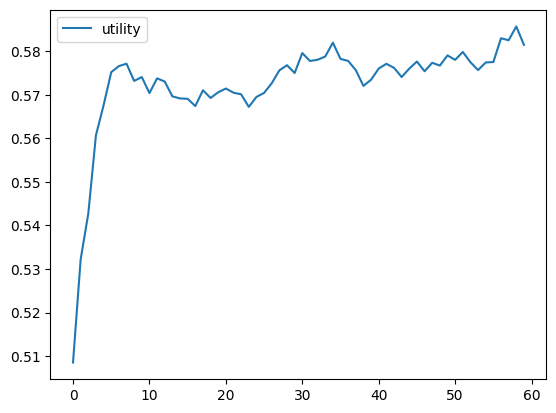

In [39]:
pd_resutls[["utility"]].plot()

In [40]:
org = pd.read_csv(org_path_results + "/results.csv")

In [41]:
def fix_results(r):
    new_r = [float(sr.split(" ")[1]) for sr in r]
    return new_r

r1 = fix_results(org.iloc[9: 64 + 9 - 3]["# Created by Octave 6.2.0"].values)
r2 = fix_results(org.iloc[74: 64 + 74 - 3]["# Created by Octave 6.2.0"].values)
r3 = fix_results(org.iloc[139: 64 + 139 - 3]["# Created by Octave 6.2.0"].values)
# r4 = fix_results(org.iloc[204: 64 + 204]["# Created by Octave 6.2.0"].values)

org_pd = pd.DataFrame([r1,r2,r3]).T
org_pd.columns = ["utility","total","fairness"]

In [42]:
org_pd

utility     total  fairness
0   0.506852 -0.190459  0.887770
1   0.518125 -0.251298  1.020722
2   0.539687 -0.395636  1.330959
3   0.551335 -0.328179  1.207693
4   0.560333 -0.326149  1.212631
..       ...       ...       ...
56  0.581704 -0.407236  1.396176
57  0.588373 -0.514486  1.617344
58  0.584481 -0.470888  1.526257
59  0.585359 -0.450287  1.485933
60  0.583901 -0.426942  1.437784

[61 rows x 3 columns]

<AxesSubplot: >

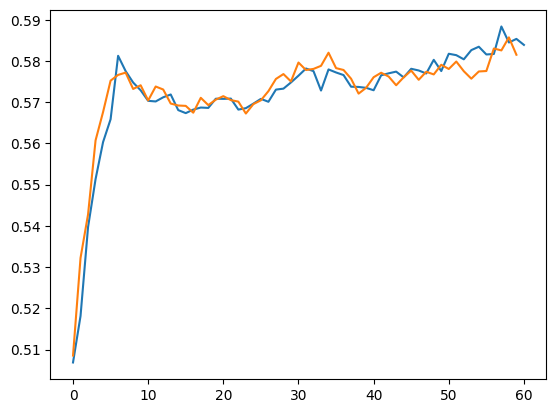

In [43]:
org_pd["utility"].plot()
pd_resutls["utility"].plot()

<AxesSubplot: >

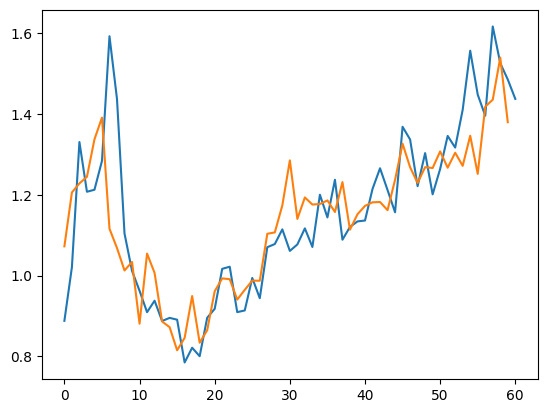

In [44]:
org_pd["fairness"].plot()
pd_resutls["fairness"].plot()

<AxesSubplot: >

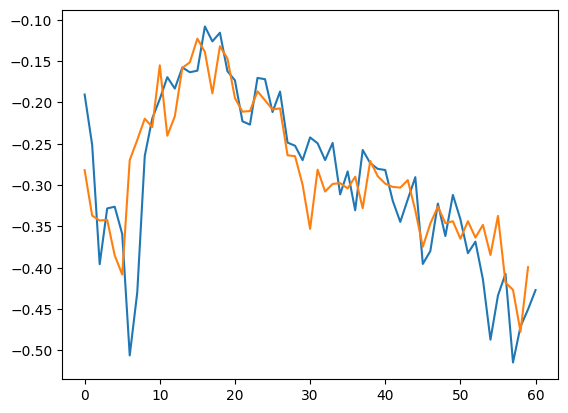

In [45]:
org_pd["total"].plot()
pd_resutls["total"].plot()

# Questions

In [ ]:
1. ProjectPolicyGradient ???